# Camera Calibration comparision


In [60]:
import os;
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Data Collection using webcam

In [61]:
def capture_webcam():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "webcam_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

In [62]:
capture_webcam()

Escape hit, closing...


# Find the cornerpoints in chessboard to know the pixel coordinates

In [63]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# objp = np.zeros((6*9,3), np.float32)           #if you use webcam images use 6*9
# objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# print (objp)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

#images=glob.glob('webcam_pics/webcam_*.png')

print(len(images))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
#   ret, corners = cv2.findChessboardCorners(gray, (9,6), None) #for webcam images
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
#     print(ret)



    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#       cv2.drawChessboardCorners(img, (9,6), corners, ret)

        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

36


## Now find the projection matrix given image points and world points

## Calibratecamera function

Input 

Obj points -- vector of vectors of calibration objpoints (3D space)

imgpoits --- vector of vector of image points (2D space)

image_size 

flags --- for various distortions

criteria for ending the iterative algorithm

Output

ret -- return value / mean reprojection error

mtx -- camera matrix 

dist -- distortion coefficients

rvecs -- output rotation vector of vectors (for each pattern view)

tvecs -- output translation vector of vector (for each pattern view)

In [64]:
import pickle
%matplotlib inline

# Test undistortion on an image
# img = cv2.imread('calibration_wide/test_image.jpg')

for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    mean_error = 0
#     print(idx)
   


In [65]:
print (ret)

0.5623861146245462


In [66]:
# # Reprojection error
# for i in range(0,len(objpoints)):
#         imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
#         error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
#         mean_error += error


# print ("total error: ", mean_error/len(objpoints))

In [67]:
# print(mtx)
mtx1=mtx
ret1=ret
# print(dist)
dist1=dist
rvecs1=rvecs
tvecs1=tvecs

## calibrateCameraExtended Function

Output:

std_in -- std deviation over intrinsic parameters

std_out -- std deviation over extrinsic parameters

per_view_error

In [68]:
import pickle
%matplotlib inline

# Test undistortion on an image
# img = cv2.imread('calibration_wide/test_image.jpg')
for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs,std_in,std_ex,per_view_error = cv2.calibrateCameraExtended(objpoints, imgpoints, img_size,None,None)
    mean_error = 0
# #     print(idx)
#     for i in range(0,len(objpoints)):
#         imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
#         error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
#         mean_error += error

In [69]:
# print(per_view_error)
# print(sum(per_view_error)/len(per_view_error))

Text(0.5, 1.0, 'Undistorted Image')

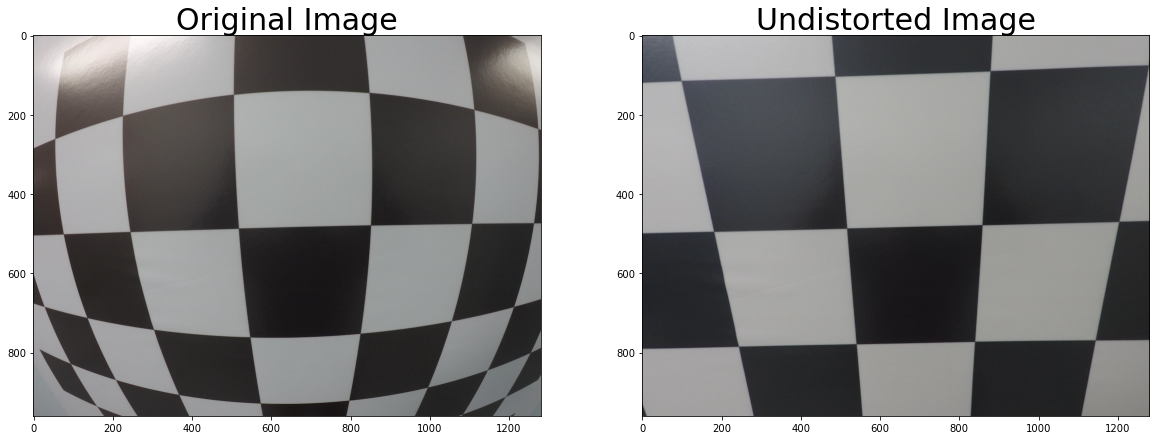

In [70]:
img = cv2.imread('calibration_wide/test_image.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# CalibrateCameraRO function

This function is an extention of calibrateCamera() where the parameters are choosen such that the intrinsic parameters are well optimized

objpts -- Vector of vectors of calibration pattern points in the calibration pattern coordinate space. See calibrateCamera() for details. If the method of releasing object to be used, the identical calibration board must be used in each view and it must be fully visible, and all objectPoints[i] must be the same and all points should be roughly close to a plane. The calibration target has to be rigid, or at least static if the camera (rather than the calibration target) is shifted for grabbing images

fixpts -- Index of fixed point

In [71]:
import pickle
%matplotlib inline


fixpts = 22 
for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs,newObjpts = cv2.calibrateCameraRO(objpoints, imgpoints, img_size,fixpts,None,None)
    mean_error = 0
#     print(idx)
    for i in range(0,len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error

In [72]:
print(ret)


0.4066069078116387


Text(0.5, 1.0, 'Undistorted Image')

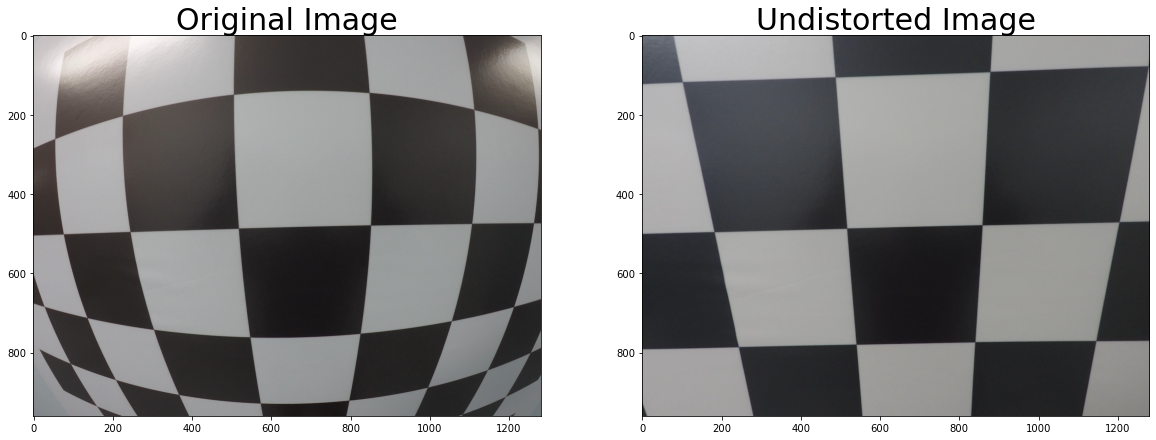

In [73]:
img = cv2.imread('calibration_wide/test_image.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [74]:
print("cameraCalibrate error---"+str(ret1))
print("cameraCalibrateRO error--"+str(ret))


cameraCalibrate error---0.5623861146245462
cameraCalibrateRO error--0.4066069078116387


In [77]:
print("camera matrix using calibrateCamera()\n\n"+str(mtx1))

camera matrix using calibrateCamera()

[[560.26807544   0.         651.26187092]
 [  0.         561.31848513 499.05499504]
 [  0.           0.           1.        ]]


In [78]:
print("camera matrix using calibrateCameraRO()\n\n"+str(mtx))

camera matrix using calibrateCameraRO()

[[556.74767495   0.         649.86984075]
 [  0.         557.03162929 492.13615516]
 [  0.           0.           1.        ]]


In [79]:
print("dist-- cameraCalibrate()\n\n"+str(dist1))
print("dist-- cameraCalibrateRO()\n\n"+str(dist))

dist-- cameraCalibrate()

[[-2.32876197e-01  6.16787717e-02 -1.40125716e-05  3.82158193e-05
  -7.54073036e-03]]
dist-- cameraCalibrateRO()

[[-2.29679518e-01  6.03221365e-02  6.87508301e-04  3.47046229e-05
  -7.32855985e-03]]


In [83]:
for i in range(0,len(objpoints)):
    print("pattern view\t"+str(i))
    print("tvecs -- cameraCalibrate()\n\n"+str(tvecs1[i]))
    print("tvecs -- calibratecameraRO()\n\n"+str(tvecs[i]))

pattern view	0
tvecs -- cameraCalibrate()

[[-2.60306216]
 [-1.38250121]
 [ 2.61848549]]
tvecs -- calibratecameraRO()

[[-2.5930227 ]
 [-1.3509901 ]
 [ 2.61632466]]
pattern view	1
tvecs -- cameraCalibrate()

[[-1.56150079]
 [-2.78547672]
 [ 4.06235135]]
tvecs -- calibratecameraRO()

[[-1.54913132]
 [-2.73820702]
 [ 4.05631298]]
pattern view	2
tvecs -- cameraCalibrate()

[[-2.10062079]
 [-2.81553806]
 [ 5.97157478]]
tvecs -- calibratecameraRO()

[[-2.08349679]
 [-2.74508766]
 [ 5.9529739 ]]
pattern view	3
tvecs -- cameraCalibrate()

[[-3.50018175]
 [-2.74871537]
 [ 3.71709193]]
tvecs -- calibratecameraRO()

[[-3.48884305]
 [-2.70416549]
 [ 3.71961961]]
pattern view	4
tvecs -- cameraCalibrate()

[[-3.42974012]
 [-2.17458829]
 [ 3.44206877]]
tvecs -- calibratecameraRO()

[[-3.41847937]
 [-2.1319074 ]
 [ 3.44290069]]
pattern view	5
tvecs -- cameraCalibrate()

[[-4.02840531]
 [-2.47114176]
 [ 4.56864005]]
tvecs -- calibratecameraRO()

[[-4.01928163]
 [-2.41607979]
 [ 4.56982962]]
pattern vi

In [84]:
for i in range(0,len(objpoints)):
    print("pattern view\t"+str(i))
    print("tvecs -- cameraCalibrate()\n\n"+str(rvecs1[i]))
    print("tvecs -- calibratecameraRO()\n\n"+str(rvecs[i]))

pattern view	0
tvecs -- cameraCalibrate()

[[ 0.26558185]
 [-0.17473256]
 [-0.04847226]]
tvecs -- calibratecameraRO()

[[ 0.25343662]
 [-0.17327406]
 [-0.04659753]]
pattern view	1
tvecs -- cameraCalibrate()

[[ 0.09306667]
 [-0.32462755]
 [-0.02489939]]
tvecs -- calibratecameraRO()

[[ 0.08156413]
 [-0.32219757]
 [-0.02150872]]
pattern view	2
tvecs -- cameraCalibrate()

[[ 0.11258532]
 [-0.1866169 ]
 [-0.03802114]]
tvecs -- calibratecameraRO()

[[ 0.10046103]
 [-0.18513494]
 [-0.03566562]]
pattern view	3
tvecs -- cameraCalibrate()

[[ 0.05157838]
 [ 0.02647601]
 [-0.01095366]]
tvecs -- calibratecameraRO()

[[ 0.04123019]
 [ 0.0271159 ]
 [-0.01032547]]
pattern view	4
tvecs -- cameraCalibrate()

[[ 0.14100898]
 [-0.03901018]
 [ 0.00317214]]
tvecs -- calibratecameraRO()

[[ 0.12978212]
 [-0.03806785]
 [ 0.00394801]]
pattern view	5
tvecs -- cameraCalibrate()

[[0.089217  ]
 [0.28755801]
 [0.00591604]]
tvecs -- calibratecameraRO()

[[0.07852693]
 [0.28713709]
 [0.00469019]]
pattern view	6
t